In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Cấu hình
plt.rcParams['font.size'] = 11
plt.rcParams['figure.figsize'] = (16, 10)
sns.set_palette("Set2")

print("📂 Đang tải dữ liệu...")
df_events = pd.read_csv('../data/udk_moodle_log.csv')
df_grades = pd.read_csv('../data/udk_moodle_all_grades.csv')
print(f"✅ Đã tải {len(df_events):,} events và {len(df_grades):,} grades")

📂 Đang tải dữ liệu...
✅ Đã tải 1,259,411 events và 20,317 grades


In [6]:
# Tính toán các features với scale khác nhau
print("\n⚙️ Đang tính toán features...")

# Feature 1: Total events per user (scale: hàng trăm đến hàng nghìn)
user_events = df_events.groupby('userid').size().reset_index(name='total_events')

# Feature 2: Average grade (scale: 0-10)
user_grades = df_grades[df_grades['finalgrade'] >= 0].groupby('userid')['finalgrade'].mean().reset_index(name='avg_grade')

# Feature 3: Event diversity (scale: chục đến vài chục)
user_diversity = df_events.groupby('userid')['eventname'].nunique().reset_index(name='event_diversity')

# Feature 4: Active days (scale: chục đến hàng trăm)
df_events['datetime'] = pd.to_datetime(df_events['timecreated'], unit='s')
user_active_days = df_events.groupby('userid')['datetime'].agg(
    lambda x: (x.max() - x.min()).days
).reset_index(name='active_days')

# Feature 5: Number of courses (scale: 1-10)
user_courses = df_events.groupby('userid')['courseid'].nunique().reset_index(name='num_courses')

# Merge tất cả features
user_features = user_events.merge(user_grades, on='userid', how='left')
user_features = user_features.merge(user_diversity, on='userid', how='left')
user_features = user_features.merge(user_active_days, on='userid', how='left')
user_features = user_features.merge(user_courses, on='userid', how='left')
user_features = user_features.fillna(0)

print("\n📊 User Features Summary:")
print(user_features.describe())

# Tính range và scale ratio
feature_stats = {
    'total_events': {'min': user_features['total_events'].min(), 
                     'max': user_features['total_events'].max(),
                     'mean': user_features['total_events'].mean(),
                     'std': user_features['total_events'].std()},
    'avg_grade': {'min': user_features['avg_grade'].min(),
                  'max': user_features['avg_grade'].max(),
                  'mean': user_features['avg_grade'].mean(),
                  'std': user_features['avg_grade'].std()},
    'event_diversity': {'min': user_features['event_diversity'].min(),
                        'max': user_features['event_diversity'].max(),
                        'mean': user_features['event_diversity'].mean(),
                        'std': user_features['event_diversity'].std()},
    'active_days': {'min': user_features['active_days'].min(),
                    'max': user_features['active_days'].max(),
                    'mean': user_features['active_days'].mean(),
                    'std': user_features['active_days'].std()},
    'num_courses': {'min': user_features['num_courses'].min(),
                    'max': user_features['num_courses'].max(),
                    'mean': user_features['num_courses'].mean(),
                    'std': user_features['num_courses'].std()}
}

print("\n📏 Scale Comparison:")
for feature, stats in feature_stats.items():
    range_val = stats['max'] - stats['min']
    print(f"  {feature}:")
    print(f"    Range: [{stats['min']:.2f}, {stats['max']:.2f}] = {range_val:.2f}")
    print(f"    Mean ± Std: {stats['mean']:.2f} ± {stats['std']:.2f}")


⚙️ Đang tính toán features...

📊 User Features Summary:
             userid  total_events    avg_grade  event_diversity  active_days  \
count   1110.000000   1110.000000  1110.000000      1110.000000  1110.000000   
mean    9068.181081   1134.604505     7.429668        27.613514   113.019820   
std     1090.568607   1781.992533     2.153648        11.130799    33.980655   
min        3.000000      1.000000     0.000000         1.000000     0.000000   
25%     8632.250000    303.750000     6.909091        21.000000   105.000000   
50%     9320.000000    624.500000     8.090909        28.000000   125.000000   
75%     9826.750000   1244.250000     8.800000        35.000000   137.000000   
max    10175.000000  30770.000000    10.000000        78.000000   145.000000   

       num_courses  
count  1110.000000  
mean      9.181081  
std       3.203723  
min       1.000000  
25%       7.000000  
50%       9.000000  
75%      11.000000  
max      29.000000  

📏 Scale Comparison:
  total_even

In [7]:
# Chuẩn bị data cho visualization
features_for_viz = ['total_events', 'avg_grade', 'event_diversity', 'active_days', 'num_courses']
X_original = user_features[features_for_viz].values

# Standardize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_original)

# Tạo DataFrame cho dễ plot
df_original = pd.DataFrame(X_original, columns=features_for_viz)
df_scaled = pd.DataFrame(X_scaled, columns=features_for_viz)


💾 Đang lưu biểu đồ...
✅ Đã lưu: challenge_2_scale_imbalance.png
✅ Đã lưu: challenge_2_scale_imbalance.pdf


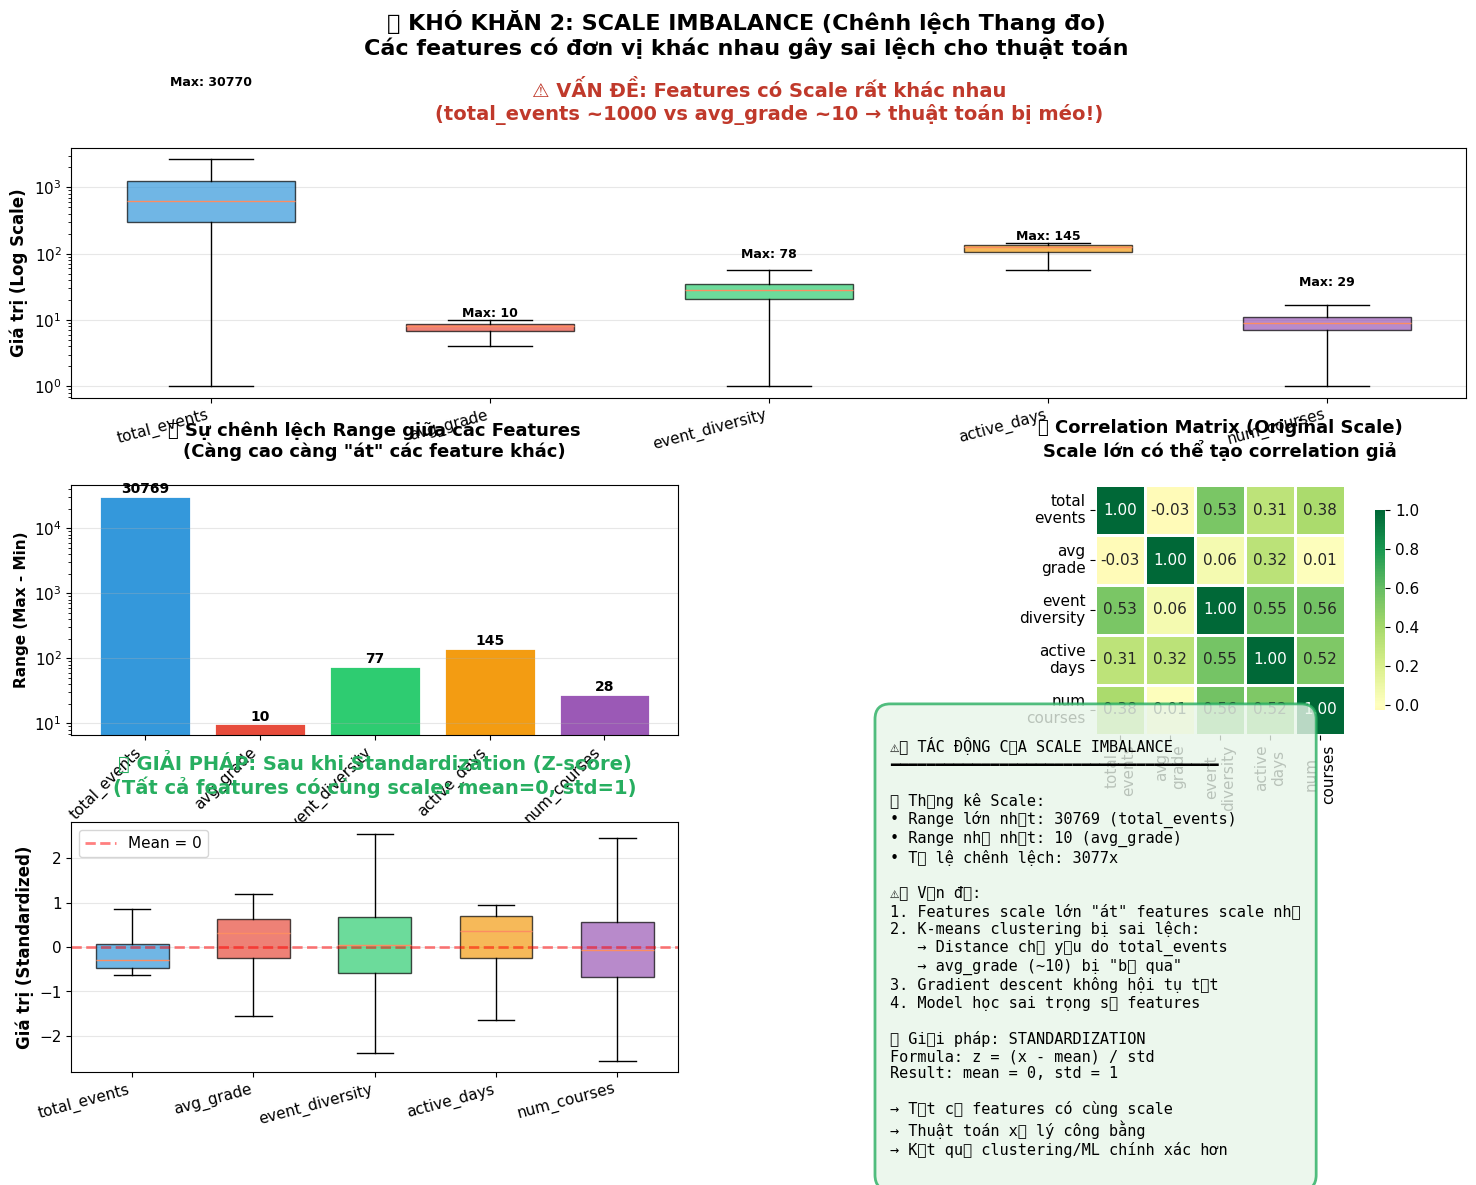


🎉 HOÀN THÀNH! Biểu đồ đã minh họa vấn đề Scale Imbalance.


In [8]:
# Tạo biểu đồ minh họa Scale Imbalance
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 2, hspace=0.35, wspace=0.3)

colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6']

# ============================================================================
# Panel 1: Box plot - Original scale (vấn đề)
# ============================================================================
ax1 = fig.add_subplot(gs[0, :])

# Không thể plot trực tiếp vì scale quá khác biệt, nên plot từng feature riêng
positions = np.arange(len(features_for_viz))
bp_data = [df_original[col].dropna() for col in features_for_viz]

bp = ax1.boxplot(bp_data, positions=positions, widths=0.6, patch_artist=True,
                 showfliers=False)  # Tắt outliers để dễ nhìn

for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax1.set_xticks(positions)
ax1.set_xticklabels(features_for_viz, rotation=15, ha='right')
ax1.set_ylabel('Giá trị (Original Scale)', fontweight='bold', fontsize=12)
ax1.set_title('⚠️ VẤN ĐỀ: Features có Scale rất khác nhau\n(total_events ~1000 vs avg_grade ~10 → thuật toán bị méo!)', 
              fontweight='bold', fontsize=14, pad=20, color='#c0392b')
ax1.grid(axis='y', alpha=0.3)
ax1.set_yscale('log')  # Log scale để thấy được tất cả
ax1.set_ylabel('Giá trị (Log Scale)', fontweight='bold', fontsize=12)

# Thêm annotation về scale
for i, (feature, stats) in enumerate(feature_stats.items()):
    ax1.text(i, stats['max'], f"Max: {stats['max']:.0f}", 
             ha='center', va='bottom', fontsize=9, fontweight='bold')

# ============================================================================
# Panel 2: Bar plot - So sánh range của các features
# ============================================================================
ax2 = fig.add_subplot(gs[1, 0])

ranges = [stats['max'] - stats['min'] for stats in feature_stats.values()]
bars = ax2.bar(range(len(features_for_viz)), ranges, color=colors, edgecolor='white', linewidth=2)
ax2.set_xticks(range(len(features_for_viz)))
ax2.set_xticklabels(features_for_viz, rotation=45, ha='right')
ax2.set_ylabel('Range (Max - Min)', fontweight='bold', fontsize=11)
ax2.set_title('📊 Sự chênh lệch Range giữa các Features\n(Càng cao càng "át" các feature khác)', 
              fontweight='bold', fontsize=13, pad=20)
ax2.set_yscale('log')
ax2.grid(axis='y', alpha=0.3)

# Thêm giá trị
for i, (bar, val) in enumerate(zip(bars, ranges)):
    ax2.text(i, val, f'{val:.0f}', ha='center', va='bottom', 
             fontsize=10, fontweight='bold')

# ============================================================================
# Panel 3: Heatmap - Correlation matrix (original scale)
# ============================================================================
ax3 = fig.add_subplot(gs[1, 1])

corr_original = df_original.corr()
sns.heatmap(corr_original, annot=True, fmt='.2f', cmap='RdYlGn', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8},
            xticklabels=[f.replace('_', '\n') for f in features_for_viz],
            yticklabels=[f.replace('_', '\n') for f in features_for_viz],
            ax=ax3)
ax3.set_title('🔥 Correlation Matrix (Original Scale)\nScale lớn có thể tạo correlation giả', 
              fontweight='bold', fontsize=13, pad=20)

# ============================================================================
# Panel 4: Box plot - Sau khi standardize (giải pháp)
# ============================================================================
ax4 = fig.add_subplot(gs[2, 0])

bp_scaled_data = [df_scaled[col].dropna() for col in features_for_viz]
bp_scaled = ax4.boxplot(bp_scaled_data, positions=positions, widths=0.6, 
                        patch_artist=True, showfliers=False)

for patch, color in zip(bp_scaled['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax4.set_xticks(positions)
ax4.set_xticklabels(features_for_viz, rotation=15, ha='right')
ax4.set_ylabel('Giá trị (Standardized)', fontweight='bold', fontsize=12)
ax4.set_title('✅ GIẢI PHÁP: Sau khi Standardization (Z-score)\n(Tất cả features có cùng scale: mean=0, std=1)', 
              fontweight='bold', fontsize=14, pad=20, color='#27ae60')
ax4.grid(axis='y', alpha=0.3)
ax4.axhline(y=0, color='red', linestyle='--', linewidth=2, alpha=0.5, label='Mean = 0')
ax4.legend()

# ============================================================================
# Panel 5: Text box - Impact & Solution
# ============================================================================
ax5 = fig.add_subplot(gs[2, 1])
ax5.axis('off')

# Tính scale ratio
max_range = max(ranges)
min_range = min([r for r in ranges if r > 0])
scale_ratio = max_range / min_range

solution_text = f"""
⚠️ TÁC ĐỘNG CỦA SCALE IMBALANCE
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 Thống kê Scale:
• Range lớn nhất: {max_range:.0f} (total_events)
• Range nhỏ nhất: {min_range:.0f} (avg_grade)
• Tỷ lệ chênh lệch: {scale_ratio:.0f}x

⚠️ Vấn đề:
1. Features scale lớn "át" features scale nhỏ
2. K-means clustering bị sai lệch:
   → Distance chủ yếu do total_events
   → avg_grade (~10) bị "bỏ qua"
3. Gradient descent không hội tụ tốt
4. Model học sai trọng số features

✅ Giải pháp: STANDARDIZATION
Formula: z = (x - mean) / std
Result: mean = 0, std = 1

→ Tất cả features có cùng scale
→ Thuật toán xử lý công bằng
→ Kết quả clustering/ML chính xác hơn
"""

ax5.text(0.05, 0.5, solution_text, fontsize=11, family='monospace',
         bbox=dict(boxstyle='round,pad=1', facecolor='#e8f5e9', alpha=0.8, 
                   edgecolor='#27ae60', linewidth=2),
         verticalalignment='center')

# ============================================================================
# Tiêu đề chính
# ============================================================================
fig.suptitle('📏 KHÓ KHĂN 2: SCALE IMBALANCE (Chênh lệch Thang đo)\nCác features có đơn vị khác nhau gây sai lệch cho thuật toán', 
             fontsize=16, fontweight='bold', y=0.995)

plt.tight_layout()

# Lưu file
print("\n💾 Đang lưu biểu đồ...")
plt.savefig('challenge_2_scale_imbalance.png', dpi=300, bbox_inches='tight', facecolor='white')
print("✅ Đã lưu: challenge_2_scale_imbalance.png")

plt.savefig('challenge_2_scale_imbalance.pdf', dpi=300, bbox_inches='tight', facecolor='white')
print("✅ Đã lưu: challenge_2_scale_imbalance.pdf")

plt.show()

print("\n🎉 HOÀN THÀNH! Biểu đồ đã minh họa vấn đề Scale Imbalance.")

## Kết luận

Biểu đồ trên minh họa:

1. **Vấn đề ban đầu**: Features có scale rất khác nhau (chênh lệch hàng trăm lần)
2. **So sánh range**: total_events có range lớn gấp nhiều lần avg_grade
3. **Correlation matrix**: Thể hiện mối quan hệ giữa các features ở original scale
4. **Giải pháp Standardization**: Đưa tất cả features về cùng scale (mean=0, std=1)
5. **Tác động & Công thức**: Giải thích rõ ràng tại sao cần standardization

Đây là bước tiền xử lý **BẮT BUỘC** trước khi áp dụng:
- K-means clustering
- Neural networks
- Bất kỳ distance-based algorithm nào